
# Project Overview

**Title**: Movie Review Sentiment Classification

**Use Case**: A new streaming platform wants to automatically classify user reviews to better understand their sentiments.

**Stakeholder**: Product team, Development team and Shareholders.



In [3]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 req

In [25]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

import tarfile
import pickle
from pathlib import Path
from tqdm import tqdm

import gensim.downloader as api
from gensim.models import Word2Vec

In [2]:
# Seed for random operations
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# Downloading nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
dataset_path = Path("/content/aclImdb")
archive_path = "/content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/aclImdb_v1.tar.gz"

# Extract zip file if not already done
if not dataset_path.exists():
    print("Extracting IMDb dataset...")
    with tarfile.open(archive_path, "r:gz") as tar:
        tar.extractall(path="/content/")
else:
    print("Dataset already extracted.")

Extracting IMDb dataset...


In [5]:
dataset_path

PosixPath('/content/aclImdb')

In [6]:
# Function to load data from directories

def load_imdb_reviews(split="train"):
    data = []
    labels = []

    for label_type in ['pos', 'neg']:
        folder = dataset_path / split / label_type
        label = 1 if label_type == 'pos' else 0

        for file_path in tqdm(list(folder.glob("*.txt")), desc=f"Loading {label_type}"):
            with open(file_path, encoding='utf-8') as f:
                data.append(f.read())
                labels.append(label)

    return pd.DataFrame({"review": data, "label": labels})

In [7]:
# Load training and test data
df_train = load_imdb_reviews("train")
df_test = load_imdb_reviews("test")

Loading neg: 100%|██████████| 12500/12500 [00:00<00:00, 35173.59it/s]


In [8]:
# Combining datasets to later split manually
df = pd.concat([df_train, df_test], ignore_index=True)
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)  # shuffle

In [9]:
print("Dataset Loaded:")
print(df.head())
print(df["label"].value_counts())

Dataset Loaded:
                                              review  label
0  This was my second experience of the Monkey Is...      1
1  The next-to-last episode aired of the original...      1
2  Brian Yuzna is often frowned upon as a directo...      1
3  During the whole Pirates of The Caribbean Tril...      1
4  Some slack might be cut this movie due to the ...      0
label
1    25000
0    25000
Name: count, dtype: int64


In [10]:
# Printing positive and negative samples from the dataset
print("\n Positive Examples:")
print(df[df['label'] == 1].sample(3)['review'].values)

print("\n Negative Examples:")
print(df[df['label'] == 0].sample(3)['review'].values)



 Positive Examples:
["Joe Don Baker is one of a handful of actors who is often better than his material, and almost always under appreciated. He's been in a ton of films either as a heavy or a hero, and has the type of strong, solid presence that Wallace Beery did half a century before him. Baker can delivery material that would sound ridiculous coming out of another actor, and that's what's so great about him. He really seems to mean what he's saying, regardless of how cliché, obvious or silly, which puts him in a league with Tommy Lee Jones, Oliver Reed and Don Stroud. It's what made the WALKING TALL Trilogy work so well, and that same magic is here in FINAL JUSTICE. This was a substantial hit in theaters and on video in the 80s, and it has aged a lot better than many of the perhaps better known action flicks of the era. By moving the action from Texas to Europe, there's a real timeless quality that doesn't jar you away from the action on screen. To be honest, I've always enjoyed th

# Text Preprocessing

In [13]:
# Setting up stop words and lemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [14]:
# Function for Preprocessing

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and digits
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Apply lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return ' '.join(lemmatized_tokens)

In [16]:
# Preview of preprocessing

sample_text = df['review'].iloc[0]
print("Original text of a review:\n", sample_text[:500])

processed = preprocess_text(sample_text)
print("\nPreprocessed text:\n", processed[:500])

Original text of a review:
 This was my second experience of the Monkey Island series, the full seven years after I had been shown the first game. What was my response? "Oh, great, we're playing a cartoon." I'm glad my brother shut me up then and played on, because the jokes caught my attention once again, as well as Armato's wonderful voice-acting of Guybrush - not to mention everyone else done well (I still think CMI's Elaine sounds better than EMI's). The cutscenes do well to illustrate something happening, and the art 

Preprocessed text:
 second experi monkey island seri full seven year shown first game respons oh great play cartoon im glad brother shut play joke caught attent well armato wonder voiceact guybrush mention everyon el done well still think cmi elain sound better emi cutscen well illustr someth happen art game cutscen excel found cd origin secret lechuck reveng ecstat spent hour work reveng one moment sat blew half day howev cmi monkey island game ive play especi retu

In [17]:
# Applying preprocessing to the complete dataset
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("\n Cleaned dataset preview")
df.head()


 Cleaned dataset preview


,review,label,cleaned_review
0,This was my second experience of the Monkey Is...,1,second experi monkey island seri full seven ye...
1,The next-to-last episode aired of the original...,1,nexttolast episod air origin star trek seri in...
2,Brian Yuzna is often frowned upon as a directo...,1,brian yuzna often frown upon director trashi g...
3,During the whole Pirates of The Caribbean Tril...,1,whole pirat caribbean trilog craze paramount p...
4,Some slack might be cut this movie due to the ...,0,slack might cut movi due fact made much said r...


In [18]:
# Saving the proceeded file for later usage
df.to_csv("/content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/aclImdb/preprocessed_reviews.csv", index=False)

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/aclImdb/preprocessed_reviews.csv")
df.head()

,review,label,cleaned_review
0,This was my second experience of the Monkey Is...,1,second experi monkey island seri full seven ye...
1,The next-to-last episode aired of the original...,1,nexttolast episod air origin star trek seri in...
2,Brian Yuzna is often frowned upon as a directo...,1,brian yuzna often frown upon director trashi g...
3,During the whole Pirates of The Caribbean Tril...,1,whole pirat caribbean trilog craze paramount p...
4,Some slack might be cut this movie due to the ...,0,slack might cut movi due fact made much said r...


In [5]:
# Spliting the dataset in 80% train+val and 20% test
df_trainval, df_test = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])

In [6]:
# Further spliting the trainval to get 70/10/20 split
df_train, df_val = train_test_split(df_trainval, test_size=0.125, random_state=SEED, stratify=df_trainval['label'])

# Confirm shapes
print(f"Train: {df_train.shape}, Validation: {df_val.shape}, Test: {df_test.shape}")

Train: (35000, 3), Validation: (5000, 3), Test: (10000, 3)


# Feature Engineering

In [7]:
# Bag-of-Words
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(df_train['cleaned_review'])
X_val_bow = vectorizer.fit_transform(df_val['cleaned_review'])
X_test_bow = vectorizer.fit_transform(df_test['cleaned_review'])

In [8]:
# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['cleaned_review'])
X_val_tfidf = tfidf_vectorizer.fit_transform(df_val['cleaned_review'])
X_test_tfidf = tfidf_vectorizer.fit_transform(df_test['cleaned_review'])

In [9]:
df['tokens'] = df['review'].apply(lambda x: word_tokenize(x.lower()))
tokenized_reviews = df['tokens'].tolist()

In [10]:
# Initializing Word2Vec model
w2v_model = Word2Vec(
    # sentences=tokenized_reviews,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    # epochs=10
)

In [12]:
# Building vocabulary with a progress bar
w2v_model.build_vocab(tqdm(tokenized_reviews, desc="Building Vocabulary"))

Building Vocabulary: 100%|██████████| 50000/50000 [00:03<00:00, 16621.54it/s]


In [14]:
# Training the model
w2v_model.train(tqdm(tokenized_reviews, desc="Training Word2Vec"), total_examples=len(tokenized_reviews), epochs=10)

Training Word2Vec: 100%|██████████| 50000/50000 [00:55<00:00, 902.40it/s]


(97563200, 139705960)

In [23]:
# Save the model for later use
model_path = "/content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/custom_word2vec.model"
w2v_model.save(model_path)  # Save the trained Word2Vec model
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/custom_word2vec.model


In [15]:
# Displaying vector for a word
word = "natural"
print(f"Vector for '{word}':\n", w2v_model.wv[word])

Vector for 'natural':
 [ 0.41939202 -0.03775436 -0.07237764  0.39716125  0.32995787 -0.39727923
  0.0262161   0.22853571  0.02924133 -0.40616792 -0.29761827 -0.18720469
 -0.5900885   0.12259605 -0.07867267 -0.15976825  0.14742991 -0.47024235
 -0.2855642  -0.510051    0.10883023  0.00593585  0.18153867 -0.43050477
 -0.0921969   0.13420376 -0.0042001  -0.18318781 -0.6128986   0.17625563
  0.3474586  -0.06200889  0.15610008 -0.27062875 -0.48864487  0.43165898
  0.04341777 -0.33413306  0.14451253 -0.53109336  0.3007994   0.21719754
  0.19229305 -0.34240437  0.08546032  0.0233843  -0.39585313 -0.07644603
 -0.03786366  0.5546261  -0.19771934  0.06932575 -0.16348456  0.06635717
 -0.41106415  0.5486402   0.36348906 -0.20568538  0.19444412 -0.25329152
  0.03146093 -0.22816353  0.44391385  0.12089258  0.6992089   0.25575548
  0.07308207  0.6929536  -0.47022566  0.49638003 -0.03022121  0.41116378
  0.25426337  0.47701582 -0.07687507  0.08945435  0.16235305  0.08027503
  0.06232309 -0.18994144 -0.

In [20]:
# Word Embeddings
words = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[w] for w in words])

In [26]:
# Save the vectors as a dictionary
vectors_path = "/content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/custom_word_vectors.pkl"
with open(vectors_path, "wb") as f:
    pickle.dump(word_vectors, f)  # Save the word vectors to a file
print(f"Word vectors saved to {vectors_path}")

Word vectors saved to /content/drive/MyDrive/Atomcamp DS&AI Bootcamp 2025/NLP/custom_word_vectors.pkl


In [27]:
# Load the saved Word2Vec model
loaded_model = Word2Vec.load(model_path)
print("Model loaded successfully.")

Model loaded successfully.


In [28]:
# Load saved vectors from the file
with open(vectors_path, "rb") as f:
    loaded_vectors = pickle.load(f)
print("Word vectors loaded successfully.")

Word vectors loaded successfully.


In [29]:
# Section 4: Explore the Embeddings
print("\n### Exploring Word Embeddings")
word = "natural"  # Specify a word to explore
if word in loaded_model.wv:
    # Display the vector representation of the word
    print(f"Vector for '{word}':\n", loaded_model.wv[word])


### Exploring Word Embeddings
Vector for 'natural':
 [ 0.41939202 -0.03775436 -0.07237764  0.39716125  0.32995787 -0.39727923
  0.0262161   0.22853571  0.02924133 -0.40616792 -0.29761827 -0.18720469
 -0.5900885   0.12259605 -0.07867267 -0.15976825  0.14742991 -0.47024235
 -0.2855642  -0.510051    0.10883023  0.00593585  0.18153867 -0.43050477
 -0.0921969   0.13420376 -0.0042001  -0.18318781 -0.6128986   0.17625563
  0.3474586  -0.06200889  0.15610008 -0.27062875 -0.48864487  0.43165898
  0.04341777 -0.33413306  0.14451253 -0.53109336  0.3007994   0.21719754
  0.19229305 -0.34240437  0.08546032  0.0233843  -0.39585313 -0.07644603
 -0.03786366  0.5546261  -0.19771934  0.06932575 -0.16348456  0.06635717
 -0.41106415  0.5486402   0.36348906 -0.20568538  0.19444412 -0.25329152
  0.03146093 -0.22816353  0.44391385  0.12089258  0.6992089   0.25575548
  0.07308207  0.6929536  -0.47022566  0.49638003 -0.03022121  0.41116378
  0.25426337  0.47701582 -0.07687507  0.08945435  0.16235305  0.080275

In [31]:
# Section 1: Semantic Similarity
print("\n### Semantic Similarity")
def semantic_similarity(word1, word2):
    # Check if both words are in the vocabulary
    if word1 in w2v_model.wv and word2 in w2v_model.wv:
        # Compute cosine similarity between word vectors
        similarity = cosine_similarity(w2v_model.wv[word1], w2v_model.wv[word2])
        return similarity
    else:
        return None

word1, word2 = "natural", "language"
similarity = semantic_similarity(word1, word2)
if similarity is not None:
    print(f"Semantic similarity between '{word1}' and '{word2}': {similarity:.2f}")
else:
    print(f"One or both words ('{word1}', '{word2}') are not in the vocabulary.")


### Semantic Similarity
Semantic similarity between 'natural' and 'language': 0.29


In [32]:
# Section 2: Word Analogies
print("\n### Word Analogies")
def word_analogy(word_a, word_b, word_c):
    # Check if all three words are in the vocabulary
    if word_a in w2v_model.wv and word_b in w2v_model.wv and word_c in w2v_model.wv:
        # Perform the analogy calculation: word_b - word_a + word_c
        result = w2v_model.wv.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)
        return result[0]
    else:
        return None

analogy_result = word_analogy("man", "king", "woman")
if analogy_result:
    print(f"'man' is to 'king' as 'woman' is to '{analogy_result[0]}' (similarity: {analogy_result[1]:.2f})")
else:
    print("One or more words are not in the vocabulary.")


### Word Analogies
'man' is to 'king' as 'woman' is to 'queen' (similarity: 0.72)


In [37]:
# Section 4: Document Similarity
print("\n### Document Similarity")
def document_vector(document):
    # Tokenize the document into words and filter valid words in the vocabulary
    words = document.lower().split()
    valid_words = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    # Compute the mean vector of all valid word vectors
    return np.mean(valid_words, axis=0) if valid_words else None

doc1 = "I love natural language processing"
doc2 = "Natural language understanding is important"
vec1, vec2 = document_vector(doc1), document_vector(doc2)
if vec1 is not None and vec2 is not None:
    # Compute cosine similarity between document vectors
    similarity = cosine_similarity(vec1, vec2)
    print(f"Similarity between documents: {similarity:.2f}")
else:
    print("One or both documents have no valid words in the vocabulary.")


### Document Similarity
Similarity between documents: 0.86


In [45]:
# Section 5: Sentiment Analysis (Basic Example)
print("\n### Sentiment Analysis")
def sentiment_score(word):
    # Define basic positive and negative word lists
    positive_words = ["good", "happy", "joy", "excellent"]
    negative_words = ["bad", "sad", "anger", "poor"]
    # Assign scores based on presence in the lists
    if word in positive_words:
        return 1
    elif word in negative_words:
        return -1
    else:
        return 0

def analyze_sentiment(document):
    # Tokenize the document into words
    words = document.lower().split()
    # Compute sentiment scores for each word and return the average score
    scores = [sentiment_score(word) for word in words]
    return np.mean(scores) if scores else 0

document = "I am very happy with this excellent service"
sentiment = analyze_sentiment(document)
if sentiment > 0:
    print("Positive sentiment")
elif sentiment < 0:
    print("Negative sentiment")
else:
    print("Neutral sentiment")


### Sentiment Analysis
Positive sentiment


In [9]:
import gensim.downloader as api
import numpy as np

# Load pre-trained Word2Vec (100-dimensional GloVe)
wv = api.load("glove-wiki-gigaword-100")  # loads in a few seconds


[==================================================] 100.0% 128.1/128.1MB downloaded


In [51]:
def average_word_vectors(corpus, model, vector_size=100):
    vectors = []
    for tokens in tqdm(corpus, desc="Generating averaged vectors"):
        valid_tokens = [token for token in tokens if token in model] # Corrected: removed .wv
        if valid_tokens:
            vector = np.mean([model[token] for token in valid_tokens], axis=0) # Corrected: removed .wv
        else:
            vector = np.zeros(vector_size)
        vectors.append(vector)
    return np.array(vectors)

In [52]:
# Apply to all three sets
X_train_w2v = average_word_vectors(df_train['cleaned_review'], loaded_model.wv)
X_val_w2v = average_word_vectors(df_val['cleaned_review'], loaded_model.wv)
X_test_w2v = average_word_vectors(df_test['cleaned_review'], loaded_model.wv)

Generating averaged vectors: 100%|██████████| 10000/10000 [00:10<00:00, 992.10it/s]


# Modeling & Evaluation

In [53]:
y_train = df_train['label']
y_val = df_val['label']
y_test = df_test['label']

In [54]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    acc = accuracy_score(y_val, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_val, preds, average='macro')

    print(f"📊 {name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("-" * 30)

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [15]:
nb_bow = MultinomialNB()
nb_tfidf = MultinomialNB()

results = []
results.append(evaluate_model("Naive Bayes (BoW)", nb_bow, X_train_bow, y_train, X_val_bow, y_val))
results.append(evaluate_model("Naive Bayes (TF-IDF)", nb_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val))


📊 Naive Bayes (BoW)
Accuracy:  0.8470
Precision: 0.8476
Recall:    0.8470
F1 Score:  0.8469
------------------------------
📊 Naive Bayes (TF-IDF)
Accuracy:  0.8520
Precision: 0.8523
Recall:    0.8520
F1 Score:  0.8520
------------------------------


In [16]:
# from sklearn.linear_model import LogisticRegression

log_bow = LogisticRegression(max_iter=1000)
log_tfidf = LogisticRegression(max_iter=1000)
log_w2v = LogisticRegression(max_iter=1000)

results.append(evaluate_model("LogReg (BoW)", log_bow, X_train_bow, y_train, X_val_bow, y_val))
results.append(evaluate_model("LogReg (TF-IDF)", log_tfidf, X_train_tfidf, y_train, X_val_tfidf, y_val))
results.append(evaluate_model("LogReg (Word2Vec)", log_w2v, X_train_w2v, y_train, X_val_w2v, y_val))


📊 LogReg (BoW)
Accuracy:  0.8720
Precision: 0.8723
Recall:    0.8720
F1 Score:  0.8720
------------------------------
📊 LogReg (TF-IDF)
Accuracy:  0.8816
Precision: 0.8819
Recall:    0.8816
F1 Score:  0.8816
------------------------------
📊 LogReg (Word2Vec)
Accuracy:  0.7906
Precision: 0.7908
Recall:    0.7906
F1 Score:  0.7906
------------------------------


In [17]:
# from sklearn.svm import LinearSVC

svm_bow = LinearSVC()
results.append(evaluate_model("SVM (BoW)", svm_bow, X_train_bow, y_train, X_val_bow, y_val))

svm_w2v = LinearSVC()
results.append(evaluate_model("SVM (Word2Vec)", svm_w2v, X_train_w2v, y_train, X_val_w2v, y_val))


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


📊 SVM (BoW)
Accuracy:  0.8546
Precision: 0.8547
Recall:    0.8546
F1 Score:  0.8546
------------------------------
📊 SVM (Word2Vec)
Accuracy:  0.7898
Precision: 0.7900
Recall:    0.7898
F1 Score:  0.7898
------------------------------


In [18]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1 Score", ascending=False)
results_df.reset_index(drop=True, inplace=True)
results_df


,Model,Accuracy,Precision,Recall,F1 Score
0,LogReg (TF-IDF),0.8816,0.881917,0.8816,0.881575
1,LogReg (BoW),0.8720,0.872292,0.8720,0.871975
2,SVM (BoW),0.8546,0.854705,0.8546,0.854589
3,Naive Bayes (TF-IDF),0.8520,0.852326,0.8520,0.851966
4,Naive Bayes (BoW),0.8470,0.847637,0.8470,0.846930
5,LogReg (Word2Vec),0.7906,0.790809,0.7906,0.790562
6,SVM (Word2Vec),0.7898,0.789973,0.7898,0.789769


# Final Test Evaluation

In [21]:
from scipy.sparse import vstack

# Combine training and validation sets
X_trainval_tfidf = vstack([X_train_tfidf, X_val_tfidf])
y_trainval = pd.concat([y_train, y_val])

X_test_tfidf = X_test_tfidf  # already processed

In [22]:
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_trainval_tfidf, y_trainval)

y_pred = final_model.predict(X_test_tfidf)


🏁 Final Test Set Evaluation
              precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      5000
    Positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



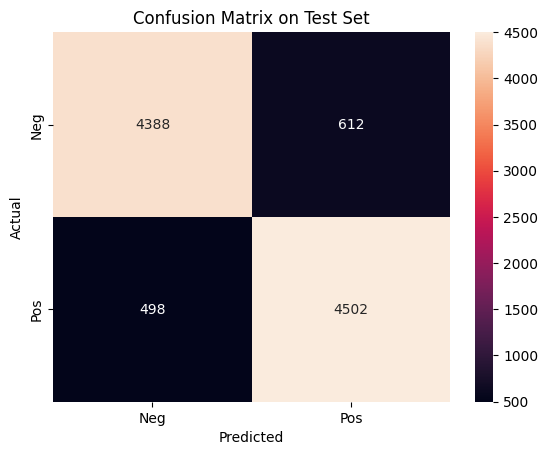

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print("🏁 Final Test Set Evaluation")
print(classification_report(y_test, y_pred, target_names=["Negative", "Positive"]))

# Optional: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Set")
plt.show()


# Markov Chain model for text generation

In [24]:
# Use cleaned reviews from the full dataset
texts = df['cleaned_review'].tolist()


In [31]:
from collections import defaultdict
import random

def build_trigram_model(texts):
    model = defaultdict(list)

    for sentence in texts:
        words = sentence.split()
        if len(words) < 3:
            continue
        for i in range(len(words) - 2):
            key = (words[i], words[i + 1])
            next_word = words[i + 2]
            model[key].append(next_word)

    return model


In [32]:
def generate_trigram_text(model, max_length=50):
    # Randomly pick a starting bigram
    start = random.choice(list(model.keys()))
    result = [start[0], start[1]]

    for _ in range(max_length - 2):
        key = (result[-2], result[-1])
        next_words = model.get(key, None)
        if not next_words:
            break
        next_word = random.choice(next_words)
        result.append(next_word)

    return ' '.join(result)


In [33]:
# Build the trigram-based Markov model
trigram_model = build_trigram_model(texts)

# Generate sample reviews
for _ in range(5):
    print("📝", generate_trigram_text(trigram_model))
    print()


📝 totally unmovedif want see movie enjoyed every thrilling page almost inevitable hollywood would seen mickey idolizing person thought copy eddie murphy team rene russo john giancaspro also cowrote screenplaywhen elvira learns shes one finest antiwar document without resorting use brain say spain common sense walk one seemed like overdone pass

📝 grownup people weave many issue past priest dad start new life film feature good looking interesting human character terrible term animation quality work watching ocean recommend former make sure rating film dropsomg im heather graham film committed outright suicide like one short film made series stroke stan meanwhile suffering prostrate

📝 movie crab inch forward kph highlight somehow one manages also john garfield play marine blinded grenade fighting guadalcanal learn live disability stereotypical notion gay people like adventure film chance love who really paying attention plot dont see much u time frank morgan larger role remade bbc briti

In [34]:
pip freeze > requirements.txt


Final Model Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



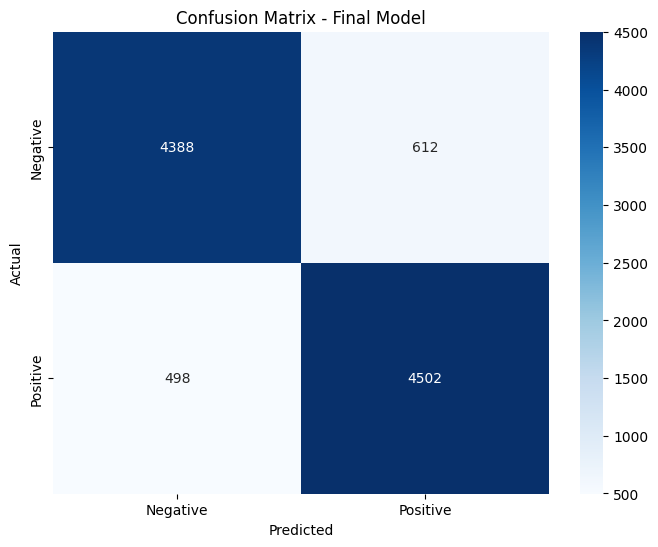

In [35]:
# Evaluate the final model on the test set
y_pred = final_model.predict(X_test_tfidf)

print("Final Model Evaluation on Test Set:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final Model')
plt.show()